### Qualitative analysis
#### 1. Calculate treatment effect variance for each word pair
> Variance for each word pair, variance among all sentence of each word pair<br>

#### 2. Fit LogisticRegression classifier
> 2.1 Label by AMT ratings <br>
> 2.2 Label by source and target <br>

#### 3. Transparency of word coeffients from LogisticRegression 
> 3.1 Map AMT labeled sentences with coefficients get from LR on user level<br>

#### 3. Find wrong cases for each method of each dataset
> 3.0 Disagreement between truth and human <br>
> 3.1 Non-perceptible cases <br>
> 3.2 Opposite perceptible cases <br>
> 3.3 Consistent perceptible cases <br>

In [1]:
import pandas as pd
import numpy as np
import pickle, ast, re
from collections import Counter
from scipy import stats, integrate
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set(color_codes=True)
np.random.seed(sum(map(ord, "distributions")))
%matplotlib inline

In [2]:
project_path = '/data/2/zwang/2018_S_WordTreatment/'
tw_path = '/data/2/zwang/2018_S_WordTreatment/V2_twitter/'
yp_path = '/data/2/zwang/2018_S_WordTreatment/V2_yelp/'
airbnb_path = '/data/2/zwang/2018_S_WordTreatment/V2_airbnb/'
amt_path = '/data/2/zwang/2018_S_WordTreatment/V2_AMT/6_amt/'
full_name = {'yp':'Yelp','tw':'Twitter','airbnb':'Airbnb'}

In [3]:
np.var([0,1,2,3,4,5,6,7,8,9])

8.25

- Calculate treatment effect variance for each word pair

In [3]:
def effect_vari(effect_file,var_file):
    for i in range(3):
        effect_pd = pd.DataFrame(pickle.load(open(effect_file[i],'rb')))
        wdpair_var = []
        for pair,effects in effect_pd.groupby(['source','target']):
            wdpair_var.append({'source':pair[0],'target':pair[1],'knn_var':np.var(effects.knn_effect.values),'vt_var':np.var(effects.vt_effect.values),
                             'ctf_var':np.var(effects.ctf_effect.values),'csf_var':np.var(effects.csf_effect.values)})

        pd.DataFrame(wdpair_var).to_csv(var_file[i],columns=['source','target','knn_var','vt_var','ctf_var','csf_var'],index=False)

In [6]:
tw_effect_file = tw_path+'5_Select/tw_wdpair_sents_4effects_posinters_poscom1_bigramcheck_limit.pickle'
yp_effect_file = yp_path+'5_Select/yp_wdpair_sents_4effects_posinters_poscom1_bigramcheck_limit.pickle'
airbnb_effect_file = airbnb_path+'5_Select/airbnb_wdpair_sents_4effects_posinters_poscom1_bigramcheck_limit_limitvocab.pickle'
tw_var_file = tw_path+'7_Vari/tw_wdpair_4effects_var.csv'
yp_var_file = yp_path+'7_Vari/yp_wdpair_4effects_var.csv'
airbnb_var_file = airbnb_path+'7_Vari/airbnb_wdpair_4effects_var.csv'
#effect_vari([tw_effect_file,yp_effect_file,airbnb_effect_file],[tw_var_file,yp_var_file,airbnb_var_file])

In [34]:
def plot_vardist(var_file,titles):
    for i in range(3):
        var_pd = pd.read_csv(var_file[i])
        print(var_pd.shape)
        
        fig, axes = plt.subplots(1, 4, figsize=(18, 3), sharex=False,sharey=True)
        axes[0].set_ylabel(titles[i])
        if(i == 0):
            var_list = ['KNN_var','VT_var','CTF_var','CSF_var']
            for j in range(len(var_list)):
                axes[j].set_title(var_list[j])
                
        sns.distplot( var_pd["knn_var"] , ax=axes[0],axlabel=False)
        sns.distplot( var_pd["vt_var"] , ax=axes[1],axlabel=False)
        sns.distplot( var_pd["ctf_var"] , ax=axes[2],axlabel=False)
        sns.distplot( var_pd["csf_var"] , ax=axes[3],axlabel=False)
        #plt.suptitle(titles[i])
        

(944, 6)
(1020, 6)
(1108, 6)


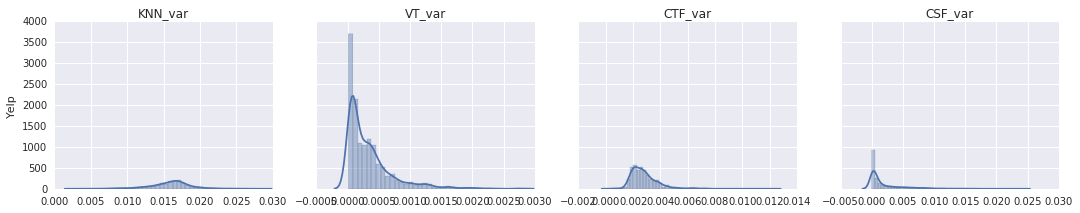

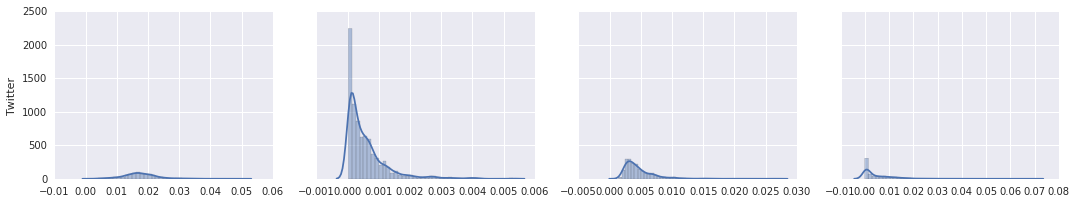

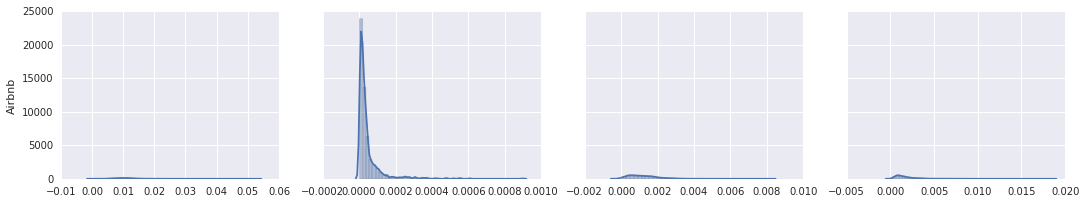

In [37]:
plot_vardist([yp_var_file,tw_var_file,airbnb_var_file],titles=['Yelp','Twitter','Airbnb'])

(1020, 6)
(944, 6)
(1108, 6)


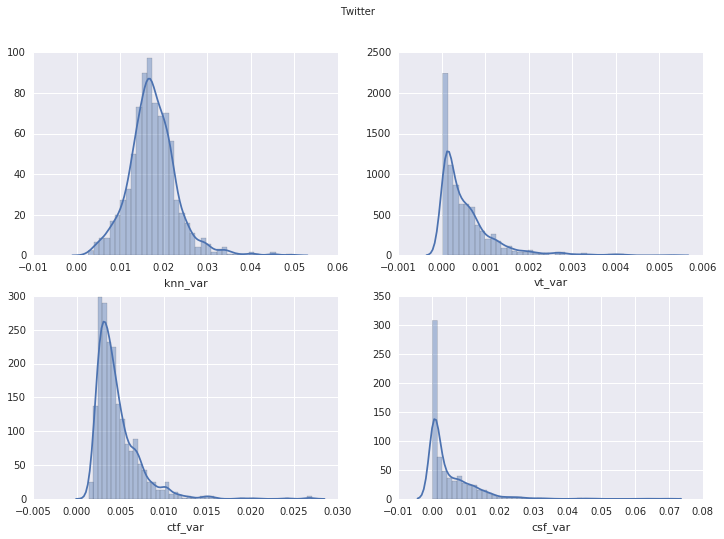

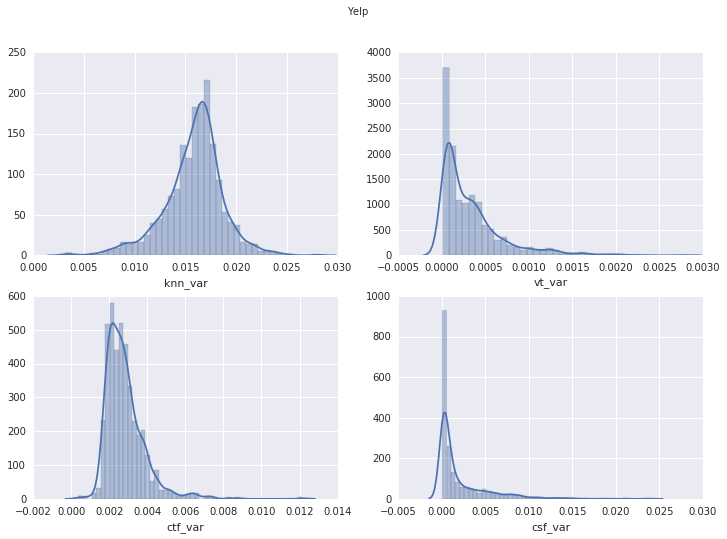

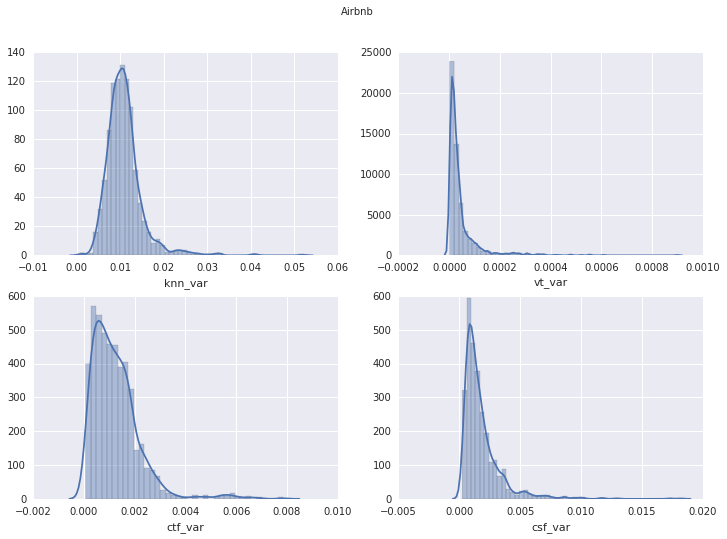

In [94]:
plot_vardist([tw_var_file,yp_var_file,airbnb_var_file],titles=['Twitter','Yelp','Airbnb'])

- Fit classifier with human labels<br>
- check if the summary file include dummy ratings<br>
- pos: median>3, neg: median < 3 <br>
- pos: median>=3, neg: median < 3 <br>
- pos: median>3, neg: median <= 3 <br>
- Print instances where median == 3 <br>

In [96]:
np.median([2, 2, 2, 3, 3, 3, 3, 3, 3, 5]) - np.median([1, 1, 2, 2, 2, 2, 2, 2, 3, 5])

1.0

#### 2. Fit classifier with human labels
> 2.1 Label by AMT ratings <br>
> 2.2 Label by source and target <br>

In [341]:
def my_get_mostcomm(rate_list):
    """
    Return the most common rating for each sentence:
        [1,1,1,2,2,2] returns 1.5
        [1,1,1] returns 1
        [1] returns 1
    """
    rate_ct = Counter(rate_list)
    if(len(rate_ct)>1):
        if(rate_ct.most_common(2)[0][1] == rate_ct.most_common(2)[1][1]):
            return (rate_ct.most_common(2)[0][0]+rate_ct.most_common(2)[1][0])/2
        else:
            return rate_ct.most_common(1)[0][0]
    else:
        return rate_ct.most_common(1)[0][0]

In [342]:
def label_by_rating(ratings):
    """
    Rating > 3, label = 1, rating < 3, label = 0, rating == 3, drop.
    """
    labels = []
    for med in ratings:
        if(med<3):
            labels.append(0)
        elif(med>3):
            labels.append(1)
    return labels

In [349]:
def LR_with_AMT(data_file, amt_method):
    """
    Label each sentence by AMT ratings, >3 as positive, <3 as negative
    Drop those with == 3
    """
    data_pd = pd.read_csv(data_file)
    if(amt_method == 'median'):
        data_pd['src_'+amt_method] = data_pd['src_ratings'].apply(lambda x: np.median(ast.literal_eval(x)))
        data_pd['tar_'+amt_method] = data_pd['tar_ratings'].apply(lambda x: np.median(ast.literal_eval(x)))
    elif(amt_method == 'mostcom'):
        data_pd['src_'+amt_method] = data_pd['src_ratings'].apply(lambda x: my_get_mostcomm(ast.literal_eval(x)))
        data_pd['tar_'+amt_method] = data_pd['tar_ratings'].apply(lambda x: my_get_mostcomm(ast.literal_eval(x)))
    
    sents_list = []
    labels = []
    
    for idx,row in data_pd.iterrows():
        src_y = 0 if row['src_'+amt_method]<3 else (1 if row['src_'+amt_method]>3 else -1)
        tar_y = 0 if row['tar_'+amt_method]<3 else (1 if row['tar_'+amt_method]>3 else -1)
        if(src_y != -1):
            sents_list.append(row.src_sentence)
            labels.append(src_y)
        if(tar_y != -1):
            sents_list.append(row.tar_sentence)
            labels.append(tar_y)
    
    ct_vec = CountVectorizer(max_df=0.8)
    X_sents = ct_vec.fit_transform(sents_list)
    
    lr_clf = LogisticRegression(random_state=42,n_jobs=-1)
    lr_clf.fit(X_sents,labels)
    print("Analysis for label by %s" % amt_method)
    print(Counter(labels))
    print("5-fold cross validation score %.3f" % (np.mean(cross_val_score(lr_clf, X_sents, labels, cv=5, scoring='roc_auc'))))
    
    feats = ct_vec.get_feature_names()
    print("\nTop 20 features in positive class:\n----------------------\n")
    for idx in lr_clf.coef_[0].argsort()[::-1][:20]:
        print("%.3f \t %s" % (lr_clf.coef_[0][idx], feats[idx]))
    
    print("\nTop 20 features in negative class:\n----------------------\n")
    for idx in lr_clf.coef_[0].argsort()[::1][:20]:
        print("%.3f \t %s" % (lr_clf.coef_[0][idx], feats[idx]))

In [350]:
data_name = 'yp'
LR_with_AMT(data_file=amt_path+'results/'+data_name+'_result_summary_nodummy.csv', amt_method='mostcom')

Analysis for label by mostcom
Counter({0: 135, 1: 41})
5-fold cross validation score 0.662

Top 20 features in positive class:
----------------------

2.127 	 buddy
0.824 	 very
0.818 	 salesperson
0.760 	 server
0.580 	 us
0.512 	 friendly
0.496 	 told
0.485 	 me
0.485 	 has
0.448 	 if
0.420 	 she
0.398 	 for
0.397 	 terrific
0.384 	 circus
0.372 	 to
0.371 	 away
0.364 	 her
0.360 	 while
0.358 	 our
0.343 	 better

Top 20 features in negative class:
----------------------

-1.384 	 boyfriend
-0.951 	 fabulous
-0.816 	 gorgeous
-0.738 	 yummy
-0.579 	 is
-0.526 	 they
-0.476 	 ever
-0.422 	 really
-0.409 	 breakfast
-0.357 	 came
-0.349 	 nice
-0.341 	 cute
-0.339 	 delightful
-0.329 	 lovely
-0.309 	 love
-0.303 	 all
-0.300 	 little
-0.279 	 ambience
-0.279 	 awesome
-0.261 	 next


In [211]:
def LR_with_srctar(data_file):
    """
    Label each sentence by (source, label = 0), (target, label = 1).
    """
    data_pd = pd.read_csv(data_file)
    
    sents_list = list(data_pd.src_sentence.values) + list(data_pd.tar_sentence.values)
    labels = list(np.zeros(data_pd.shape[0])) + list(np.ones(data_pd.shape[0]))
    
    ct_vec = CountVectorizer()
    X_sents = ct_vec.fit_transform(sents_list)
    
    lr_clf = LogisticRegression(random_state=42,n_jobs=-1)
    lr_clf.fit(X_sents,labels)
    print("Analysis for label by source and target:")
    print(Counter(labels))
    print("5-fold cross validation score %.3f" % (np.mean(cross_val_score(lr_clf, X_sents, labels, cv=5, scoring='roc_auc'))))
    
    # Coverage of top-20 word features
    pos_cov = 0
    neg_cov = 0
    feats = ct_vec.get_feature_names()
    print("\nTop 20 features in positive class:\n----------------------\n")
    for idx in lr_clf.coef_[0].argsort()[::-1][:20]:
        print("%.3f \t %s" % (lr_clf.coef_[0][idx], feats[idx]))
        if(feats[idx] in data_pd.target.values):
            pos_cov += 1
    
    print("\nTop 20 features in negative class:\n----------------------\n")
    for idx in lr_clf.coef_[0].argsort()[::1][:20]:
        print("%.3f \t %s" % (lr_clf.coef_[0][idx], feats[idx]))
        if(feats[idx] in data_pd.source.values):
            neg_cov += 1
    
    print("Top-20 words coverage: (pos,%.3f), (neg,%.3f)" % (pos_cov/20 , neg_cov/20))

In [214]:
data_name = 'airbnb'
LR_with_srctar(data_file=amt_path+'results/'+data_name+'_result_summary_nodummy.csv')

Analysis for label by source and target:
Counter({0.0: 120, 1.0: 120})
5-fold cross validation score 0.785

Top 20 features in positive class:
----------------------

1.457 	 spectacular
1.207 	 inexpensive
1.195 	 outstanding
1.164 	 excellent
1.048 	 especially
1.001 	 fabulous
0.947 	 cozy
0.887 	 wonderful
0.885 	 festivals
0.873 	 condo
0.855 	 boutique
0.850 	 plaza
0.837 	 tours
0.833 	 nicest
0.831 	 gorgeous
0.823 	 quickly
0.799 	 unique
0.790 	 vibrant
0.771 	 several
0.711 	 good

Top 20 features in negative class:
----------------------

-2.645 	 famous
-2.562 	 amazing
-2.010 	 exciting
-1.840 	 predominantly
-1.482 	 yummy
-1.383 	 cheap
-1.023 	 apartments
-0.936 	 various
-0.930 	 notable
-0.929 	 dynamic
-0.926 	 trips
-0.918 	 rapidly
-0.903 	 square
-0.889 	 store
-0.875 	 events
-0.849 	 open
-0.819 	 apartment
-0.817 	 hot
-0.795 	 huge
-0.771 	 comfortable
Top-20 words coverage: (pos,1.000), (neg,1.000)


In [209]:
data_file=amt_path+'results/tw_result_summary_nodummy.csv'
data_pd = pd.read_csv(data_file)

In [210]:
data_pd[['source','target']].drop_duplicates(['source','target']).reset_index(drop=True).shape

(25, 2)

#### 3. Find wrong cases for each method of each dataset
> Take most_common as AMT effects <br>
> 3.0 Disagreement between truth and human <br>
> 3.1 Non-perceptible cases <br>
> 3.2 Opposite perceptible cases <br>
> 3.3 Consistent perceptible cases <br>

In [339]:
def cal_disagree(amt_method):
    """
    Calculate agreement between truth label and human rating for source sentence.
    If truth label is not agree with amt rating, then this instance might not be labeled correctly.
    """
    disagree_info = {}
    for data_name in ['airbnb','tw','yp']:
        data_pd = pd.read_csv(amt_path+'results/'+data_name+'_result_summary_nodummy.csv')
        agree_csv = amt_path+'results/'+data_name+'_result_summary_agree.csv'
        data_pd['src_truth'] = data_pd[amt_method].apply(lambda col: 1 if col > 3 else (0 if col < 3 else -1))
        agree_pd = data_pd[data_pd['src_truth'] == data_pd['true_y']] 
        disagree_info[full_name[data_name]] = round(agree_pd.shape[0]/data_pd.shape[0],3)
        agree_pd.to_csv(agree_csv,index=False)
    
    display(pd.DataFrame(disagree_info,index=['label_agreement']))

In [340]:
cal_disagree(amt_method='amt_effect_median')

,Airbnb,Twitter,Yelp
label_agreement,0.383,0.625,0.708


In [219]:
all_treat_effect = ['knn_effect','vt_effect','ctf_effect','csf_effect']

In [293]:
def get_wrong_perct(amt_path,amt_method):
    """
    Calculate percentage for non-perceptible, opposite and consistent cases.
    """
    for data_name in ['airbnb','tw','yp']:
        data_pd = pd.read_csv(amt_path+'results/'+data_name+'_result_summary_nodummy.csv')
        perct_info = {}
        for treat_method in all_treat_effect:
            ct_perct = Counter(np.sign(data_pd[treat_method] * data_pd[amt_method]))
            perct_info[treat_method] = ['%.3f' % (round(ct_perct[0.0]/data_pd.shape[0],3)),
                                        '%.3f' % (round(ct_perct[-1.0]/data_pd.shape[0],3)),
                                        '%.3f' % (round(ct_perct[1.0]/data_pd.shape[0],3))]
        
        print("%s dataset:" % full_name[data_name])
        display(pd.DataFrame(perct_info,columns=all_treat_effect).rename({0:'non-perceptible',1:'opposite',2:'consistent'}))

In [294]:
get_wrong_perct(amt_path,amt_method='amt_effect_mostcom')

Airbnb dataset:


,knn_effect,vt_effect,ctf_effect,csf_effect
non-perceptible,0.633,0.608,0.608,0.608
opposite,0.150,0.100,0.108,0.133
consistent,0.217,0.292,0.283,0.258


Twitter dataset:


,knn_effect,vt_effect,ctf_effect,csf_effect
non-perceptible,0.383,0.375,0.375,0.375
opposite,0.158,0.150,0.150,0.158
consistent,0.458,0.475,0.475,0.467


Yelp dataset:


,knn_effect,vt_effect,ctf_effect,csf_effect
non-perceptible,0.342,0.342,0.342,0.342
opposite,0.150,0.150,0.150,0.150
consistent,0.508,0.508,0.508,0.508


In [322]:
test_pd = pd.read_csv(amt_path+'results/yp_result_summary_nodummy.csv')

In [327]:
test_pd[(test_pd.source == 'yummy') & (test_pd.target=='delightful')]

,source,target,src_sentence,tar_sentence,knn_effect,vt_effect,ctf_effect,csf_effect,true_y,id,src_ratings,tar_ratings,amt_effect_mean,amt_effect_median,amt_effect_mostcom
18,yummy,delightful,Seriously yummy PhÃ² !,Seriously delightful PhÃ² !,0.96667,0.08677,0.20122,0.19412,0,2715047,"[1, 1, 1, 2, 2, 2, 2, 2, 2, 5]","[1, 1, 2, 2, 2, 3, 3, 3, 4, 4]",0.5,0.5,0.5
19,yummy,delightful,A nice Hawaiian spin on Chipotle/Qdoba-type bu...,A nice Hawaiian spin on Chipotle/Qdoba-type bu...,-0.13333,0.03149,0.07415,0.19966,0,2714703,"[1, 2, 2, 2, 2, 2, 2, 3, 4, 5]","[2, 2, 2, 2, 2, 2, 2, 2, 3, 5]",-0.1,0.0,0.0
20,yummy,delightful,Both yummy but i especially liked the fried ca...,Both delightful but i especially liked the fri...,0.23333,0.08407,0.23388,0.20627,1,2713776,"[1, 1, 1, 2, 2, 2, 2, 2, 3, 3]","[2, 2, 2, 3, 3, 3, 3, 3, 3, 4]",0.9,1.0,1.0


In [319]:
def topn_wrong_sentences(amt_path,amt_method,topn):
    """
    Get topn sentences for each case: [non-perceptible, opposite, consistent]
    """
    
    for data_name in ['yp','tw','airbnb']:
        print("Processing %s dataset" % full_name[data_name])
        data_pd = pd.read_csv(amt_path+'results/'+data_name+'_result_summary_nodummy.csv')
        res_csv = amt_path+'topn_wrong/'+data_name+'_topn_wrong_cases.csv'
        wrong_sents = []
        for treat_method in all_treat_effect:
            select_cols = ['source','target',treat_method,amt_method,'src_sentence']
            data_pd['effect_relate'] = data_pd[treat_method] * data_pd[amt_method]
            opp_cases = data_pd[data_pd.effect_relate < 0].sort(columns=treat_method,ascending=False).iloc[:topn][select_cols]
            nonp_cases = data_pd[data_pd.effect_relate == 0].sort(columns=treat_method,ascending=False).iloc[:topn][select_cols]
            consist_cases = data_pd[data_pd.effect_relate > 0].sort(columns=treat_method,ascending=False).iloc[:topn][select_cols]
            wrong_sents.extend([opp_cases,nonp_cases,consist_cases])
        pd.concat(wrong_sents).to_csv(res_csv)

In [321]:
topn_wrong_sentences(amt_path,amt_method='amt_effect_mostcom',topn=3)

Processing Yelp dataset
Processing Twitter dataset
Processing Airbnb dataset


/usr/lib/python3.4/site-packages/ipykernel/__main__.py:14: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/usr/lib/python3.4/site-packages/ipykernel/__main__.py:15: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/usr/lib/python3.4/site-packages/ipykernel/__main__.py:16: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
